In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.constants import Planck
from scipy.constants import speed_of_light

n=32 #n+1=amount of csv files
k=27 #k+1=actual amount of files used (not using detuning 16 as of now)

#import pandas as pd
#df=pd.read_csv('Part II/-5_B7.5/F0000CH2.csv', sep=',', header = None)
#print(df)

In [46]:
I_sat=4.1 #mW/cm^2, Saturation Intensity taken from F20.pdf page 82
lw=2*np.pi*6.07 #MHz, Natural Line Width of RB 85 (what about 87?) taken from F20.pdf page 82
Trans=0.96 #a.u., Transmission of the optical viewport taken from F20.pdf page 83
radius=25.4 #mm, radius of the collecting lense taken from F20.pdf page 83
distance=150 #mm, distance between MOT and Photodiode taken from F20.pdf page 83
G=4.75e6 #V/A, Gain of Photdiode amplifier at +70dB taken from F20.pdf page 83
Gf=G*0.05 #V/A, Error of G taken from F20.pdf page 83
QE=0.52 #A/W, Quantum Efficiency of the sensor taken from F20.pdf page 83
QEf=0.015 #A/W, Error of QE taken from F20.pdf page 83
S=1e6/(1e6+50) #a.u., Scale Factor cause by impedance difference taken from F20.pdf page 83
sp_85=384.230406373e12 #Hz, S->P transition for RB85 taken from F20.pdf page 19
sf3_85=1.264888e9 #Hz, deltaF in S for F=3 for RB85 taken from F20.pdf page 19
pf2_85=83.835e6 #Hz, deltaF in P for F=2 for RB85 taken from F20.pdf page 19
pf4_85=100.205e6 #Hz, deltaF in P for F=4 for RB85 taken from F20.pdf page 19
powerx=8 #mW, Laserpower in x direction
powery=8 #mW, Laserpower in y direction
powerz=18 #mW, Laserpower in z direction
omega=0.2 #cm, width of Laser Beam taken from F20.pdf page 83
amount=2500 #data sets per .csv
red_amount=2250 # reduced data sets per .csv
narr=np.arange(n+1,dtype=int) #array for loop
karr=np.arange(k+1,dtype=int) #array for another loop
detuning=([5,6,7,8,10,12,14,16]) #array for indexing detuning
#arrays for current indexing current
current75=([0,4,8,12,16,20,24,29]) 
current8=([1,5,9,13,17,21,25,30])
current85=([2,6,10,14,18,22,27,31])
current9=([3,7,11,15,19,23,28,32])
#linspace for Loadingtime plot
tplot=np.linspace(0,5,5000)

In [47]:
#defining constant fit function for background noise
def con(x,b): 
    return 0*x+b

#defining laserintensity
def I_r():
    return 2*(powerx+powery+powerz)/(np.pi*omega**2)

#defining solid angle theta for conversion
def theta():
    return radius**2/(4*distance**2)

#defining scatteringRate for conversion
def scatteringRate(detuning):
    I_0 = I_r()
    resultScatteringRate = (lw/2)*(I_0/I_sat)/(1+I_0/I_sat+4*detuning**2/lw**2)
    return resultScatteringRate

#defining wavelength with detuning for conversion
def wavelength(detuning):
    return speed_of_light/(sp_85-sf3_85+(pf4_85-pf2_85)/2-detuning)

#defining energy from a phton with wavelength(detuning) for conversion
def energy(detuning):
    energyCalc = Planck*speed_of_light/wavelength(detuning)
    return energyCalc

In [48]:
#reading out the csv and returning time and voltage as arrays
def grabData(file):
    #file is string with form :
    #'Part II/-<absolute detuning value>_B<value of the current>/F<# of csv with 4 digits>CH1.csv'
    #for example 'Part II/-6_B7.5/F0001.csv'
    dg = np.genfromtxt(file, delimiter=',')
    #6 dim array with most of them being 'empty' caused by the way Oscilloscope writes the .csv
    #Example of the first 3 'lines', column 0 and 1 become NaN as well after 17 lines
#                   0                   1   2      3     4   5
#0        Record Length        2.500000e+03 NaN  0.000  3.04 NaN
#1      Sample Interval        1.000000e-03 NaN  0.001  3.02 NaN
#2        Trigger Point  0.000000000000e+00 NaN  0.002  3.02 NaN
    g0,g1,g2,g3,g4,g5 = np.hsplit(dg,6)
    #g3=time, g4=voltage
    return g3,g4

#translating voltage into #atoms
def conversion(voltage,detuning):
    scat = scatteringRate(detuning)
    eng = energy(detuning)
    angle = theta()
    natoms = voltage/(QE*G*S*Trans*angle*scat*eng)
    return natoms



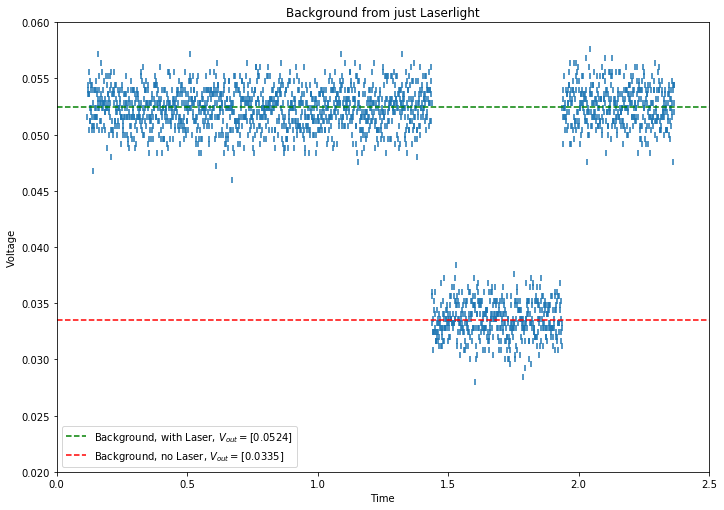

In [49]:
#Determinging the Background being measured by the ccd with and without laser
t0b, background = grabData('Part II/Background/F0033CH1.csv') #change folder 'Part II if needed'

#filtering 250 values
t1b = t0b[np.where(background > 0.025)]
back = background[np.where(background > 0.025)]

#ubb = background with laser (ubackgroundbright) in V
xbb = t0b[np.where(background > 0.043)]
ybb = background[np.where(background > 0.043)]
ubb, fbb = curve_fit(con,xbb,ybb)

#ubd = background without laser (ubackgrounddark) in V
xb = t0b[np.where(background < 0.043)]
yb = background[np.where(background < 0.043)]
xbd = xb[np.where(yb > 0.025)]
ybd = yb[np.where(yb > 0.025)]
ubd, fbd = curve_fit(con,xbd,ybd)

#plot background means
xlin=np.arange(4)
plt.scatter(t1b,back,marker="|")
plt.plot(xlin,con(xlin,ubb),'green',linestyle='--',
        label='Background, with Laser, $V_{out}=$'+str(np.round(ubb,4)))
plt.plot(xlin,con(xlin,ubd),'red',linestyle='--',
         label='Background, no Laser, $V_{out}=$'+str(np.round(ubd,4)))

plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend(loc='lower left')
plt.xlim(0,2.5)
plt.ylim(0.02,0.06)
plt.title('Background from just Laserlight')
plt.gcf().set_size_inches(11.69, 8.27)
plt.show()

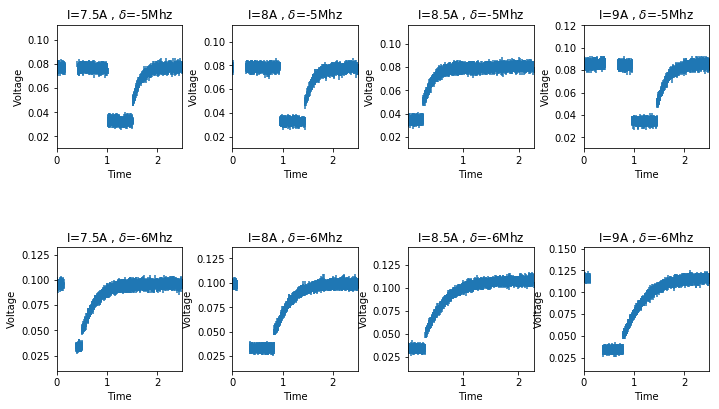

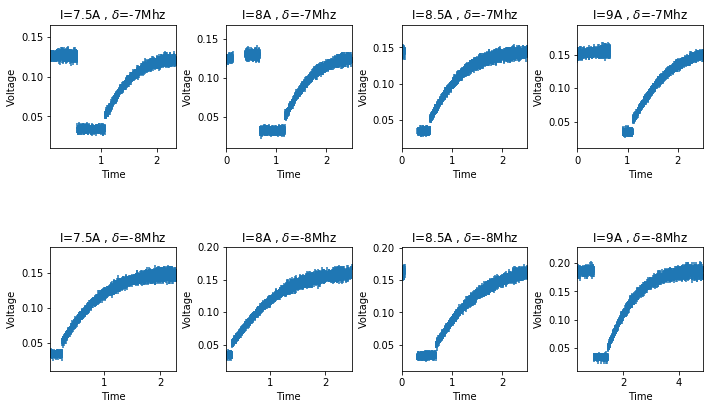

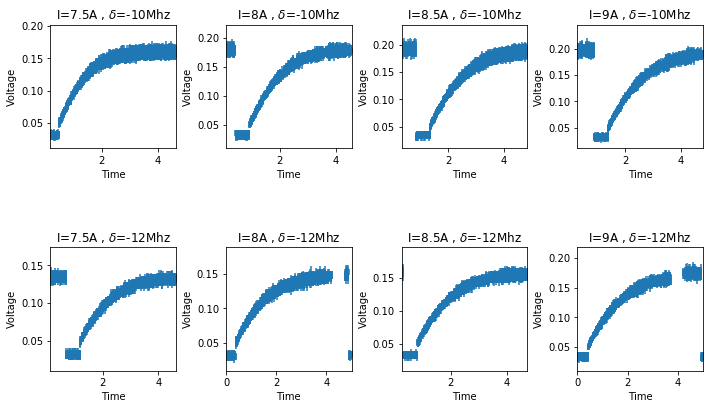

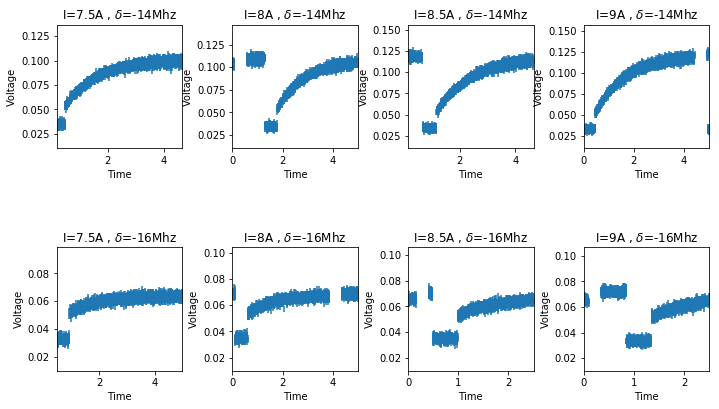

In [50]:
#Reading out all 33 Files, we skip one file so we end up with 32
#create empty array that we fill, when called it gives back data according to: 
#array[file index(0-31),value(0-2499),specify(0-2)] specify: 0=detuning[MHz], 1=current[A], 2=value
t_all = np.empty((n,amount,3))
u_all = np.empty((n,amount,3))
for i in narr: 
    if(i==0): j=1
    if(i==26): continue #removed cause we have this data set 2 times and this one was worse
    #building the string to read next file 
    #part I: F<4 digits number of .csv starts at 0000>
    if(i<10):
        c='F000'+str(i)
    else:
        c='F00'+str(i)
    #part II: <value of current> and adding counter for current for array
    if(i in current75):
        b='7.5'
        r=7.5
    if(i in current8):
        b='8'
        r=8
    if(i in current85):
        b='8.5'
        r=8.5
    if(i in current9):
        b='9'
        r=9
    #part III: <abolsute detuning value> and adding counter for detuning for array
    if(i<4):
        a=str(5)
        z=detuning[0]
    elif(i<8):
        a=str(6)
        z=detuning[1]
    elif(i<12):
        a=str(7)
        z=detuning[2]
    elif(i<16):
        a=str(8)
        z=detuning[3]
    elif(i<20):
        a=str(10)
        z=detuning[4]
    elif(i<24):
        a=str(12)
        z=detuning[5]
    elif(i<29):
        a=str(14)
        z=detuning[6]
    else:
        a=str(16)
        z=detuning[7]
    #patching together the actual path
    path = 'Part II/-'+a+'_B'+b+'/'+c+'CH1.csv' 
    t,u = grabData(path)
    #everything up till here was just to read out the .csv
    #filling the arrays with i==26 exception rule
    if(i<26):
        u_all[i,:]=u
        u_all[i,:,1]=r
        u_all[i,:,0]=z
        t_all[i,:]=t
        t_all[i,:,1]=r
        t_all[i,:,0]=z
    else:
        u_all[i-1,]=u 
        u_all[i-1,:,1]=r
        u_all[i-1,:,0]=z
        t_all[i-1,:]=t
        t_all[i-1,:,1]=r
        t_all[i-1,:,0]=z
    #drawing the subplots of just data while leaving "error" signals below 0.025V out 
    t = t[np.where(u > 0.025)]
    u = u[np.where(u > 0.025)] 
    plt.subplot(2,4,j)
    plt.scatter(t,u,marker="|") 
    plt.xlim(t[0],t[-1])
    ymax=np.amax(u)+0.03
    plt.ylim(0.01,ymax)
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title('I='+b+'A , $\delta$=-'+a+'Mhz')
    #every 8 subplots = 1 picture
    j=j+1
    if(j>8): 
        plt.subplots_adjust(wspace=0.4,hspace=0.8)
        plt.gcf().set_size_inches(11.69, 8.27/1.3)
        plt.show()
        j=1
    #clean up    
    del t,u,z,r,a,b,c,path

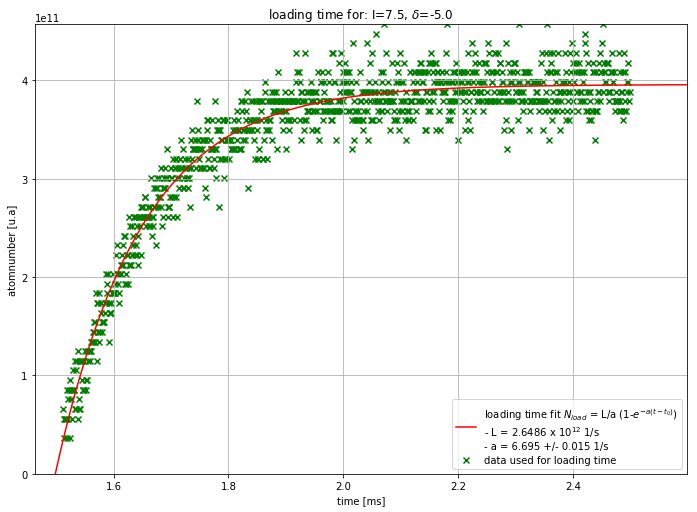

1.498139883279034


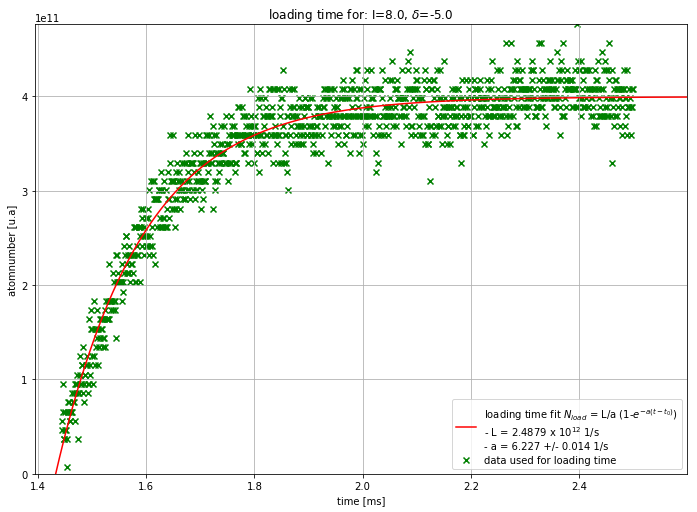

1.4329885214927718


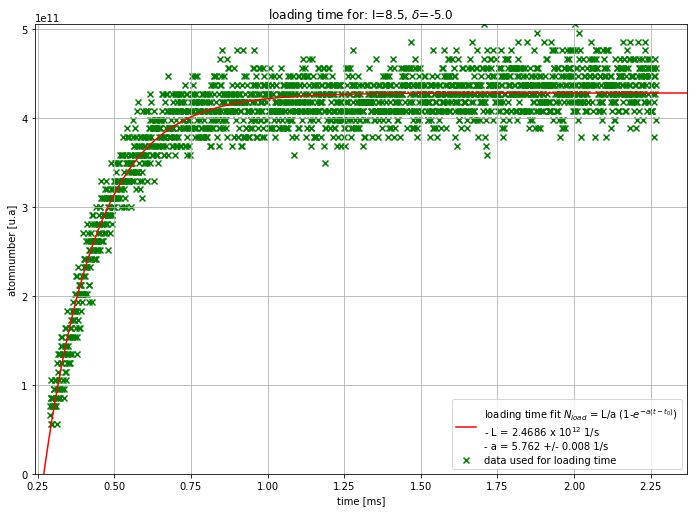

0.2701124301972159


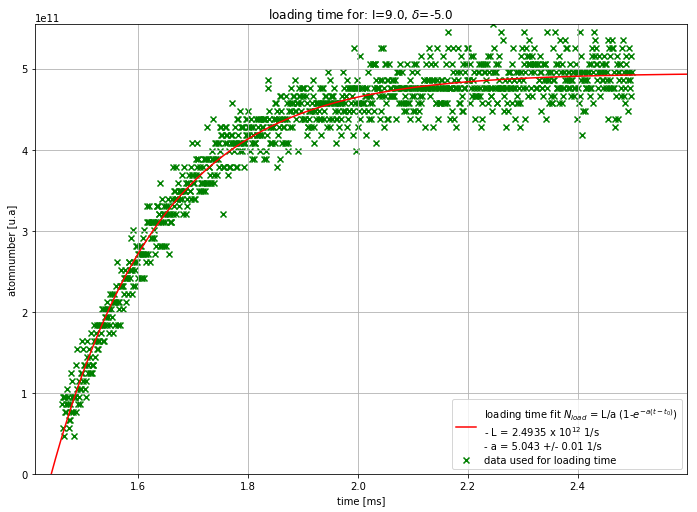

1.442449848325731


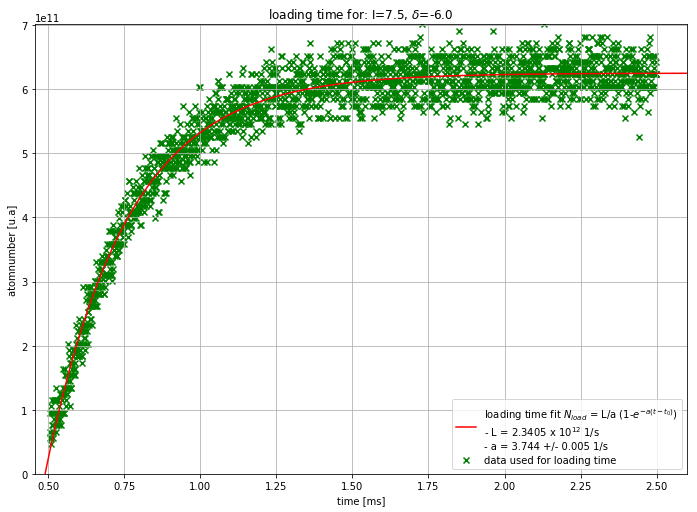

0.49055688554979526


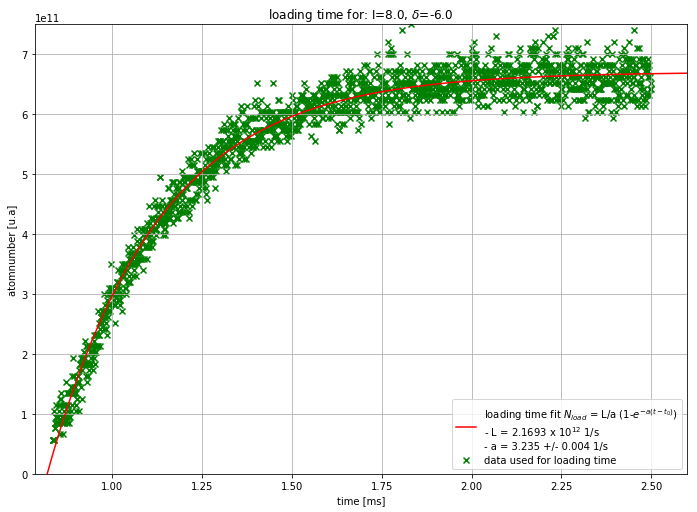

0.8191734576288497


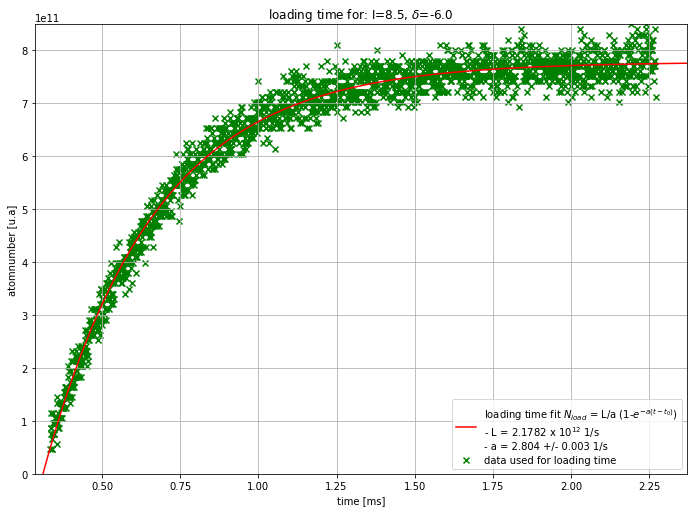

0.31084402736213446


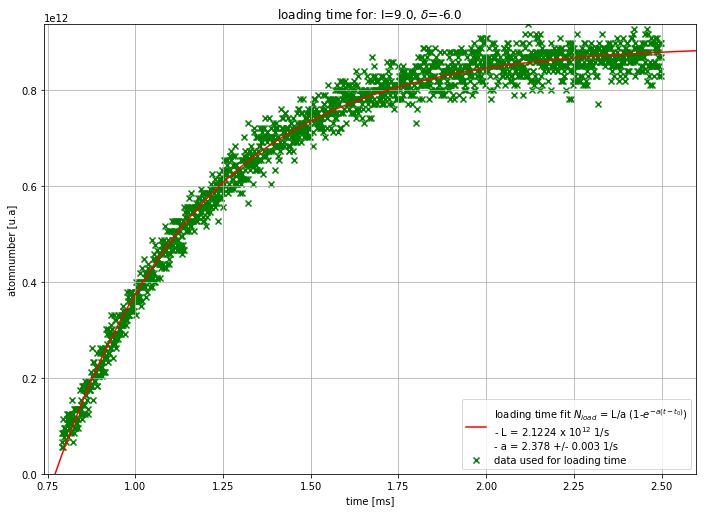

0.7715758399416242


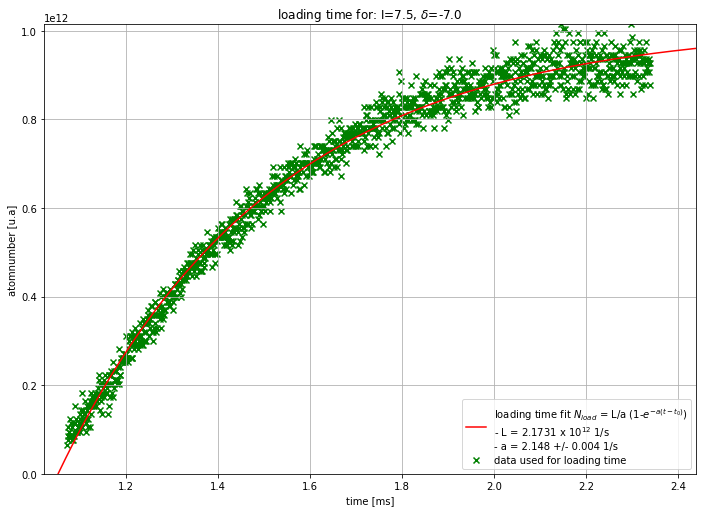

1.0534512276738952


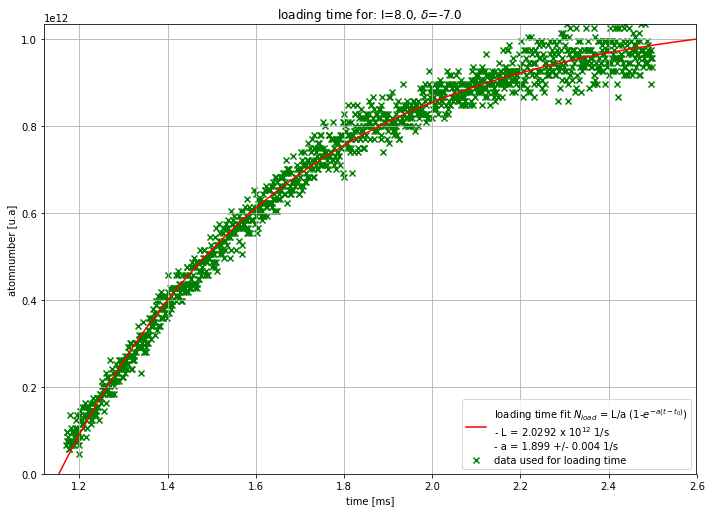

1.1536658730379756


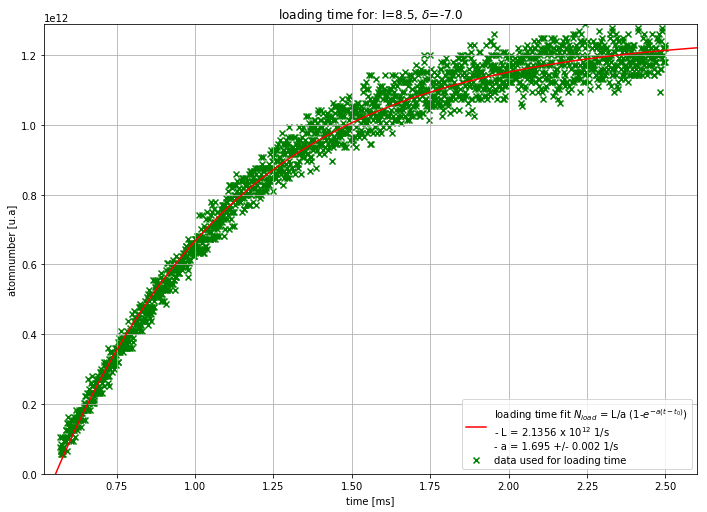

0.5553869705774125


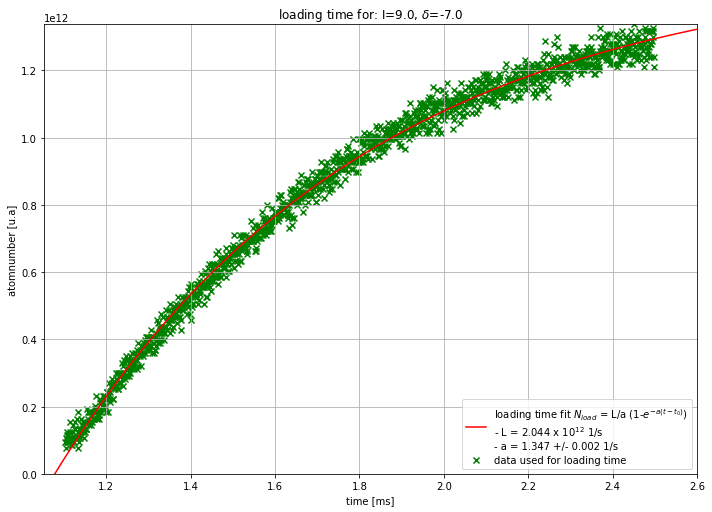

1.0781359855403378


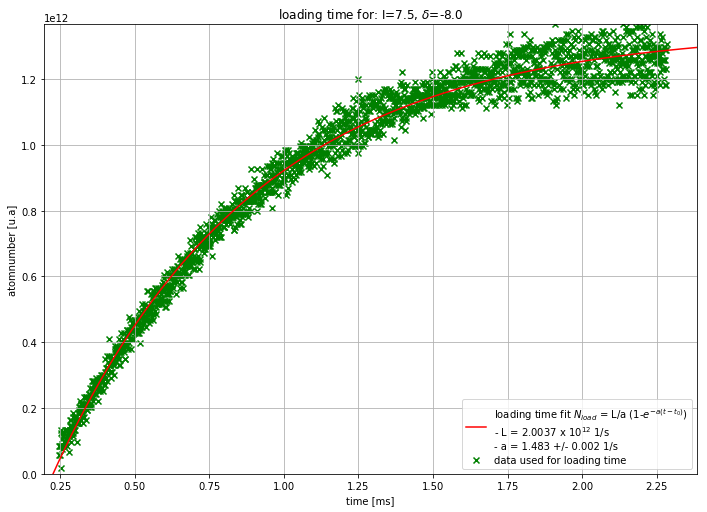

0.22665651524403518


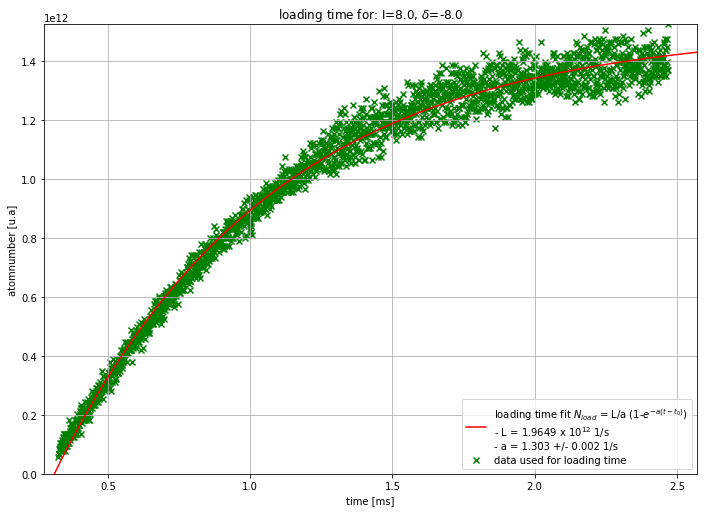

0.3117276300153883


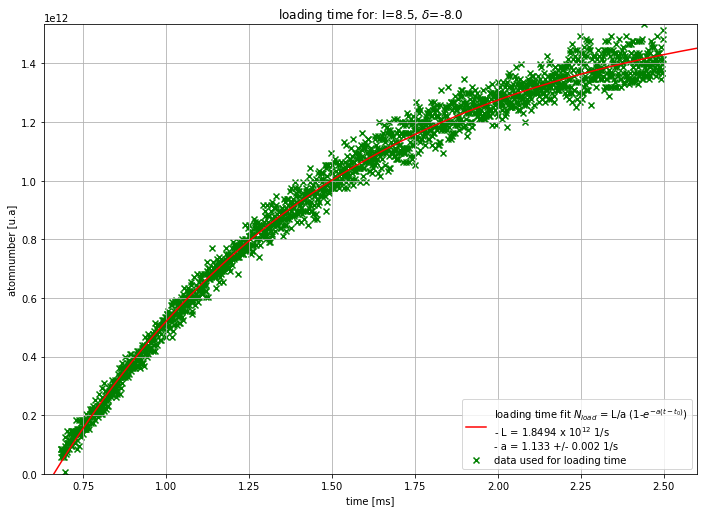

0.6611337017402296


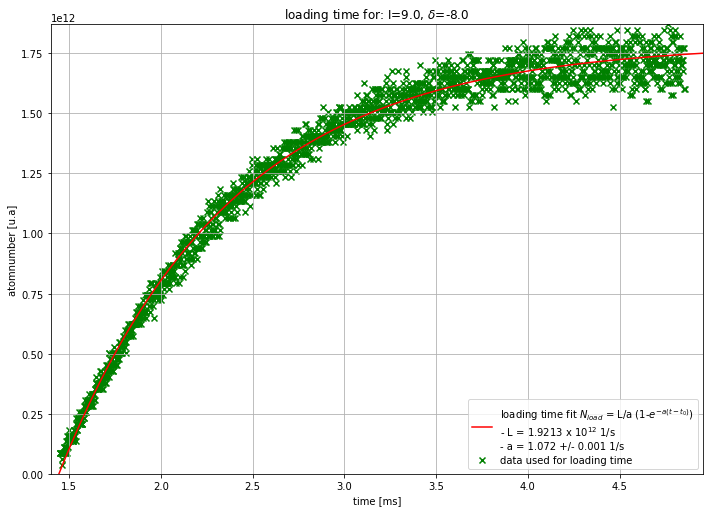

1.4434425284042265


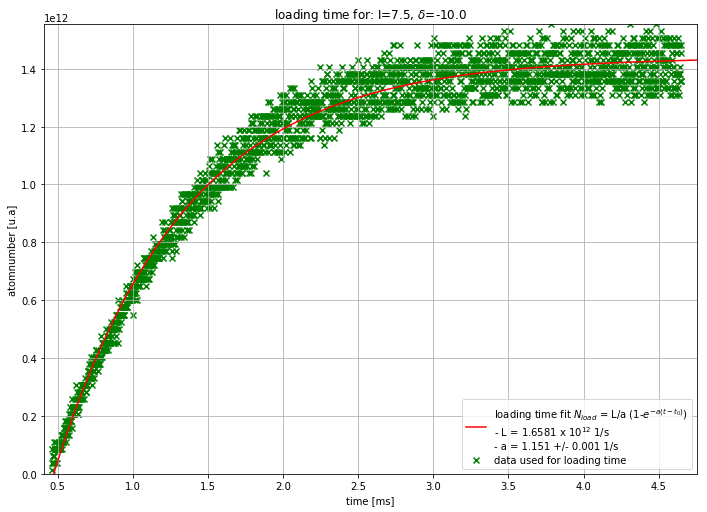

0.4729323786819939


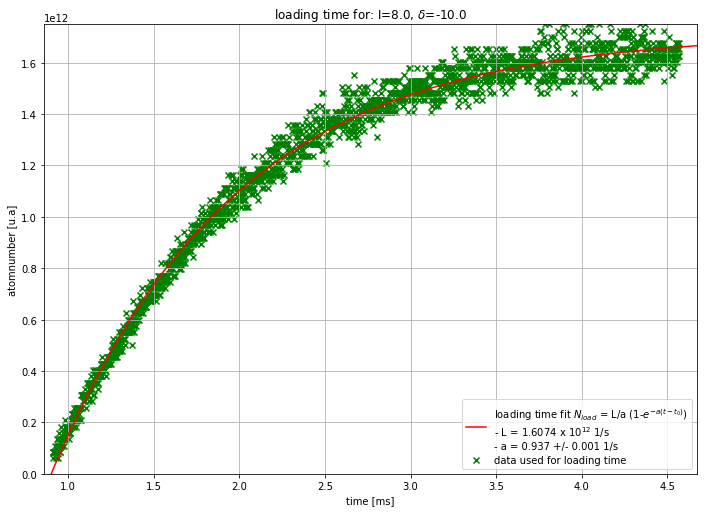

0.9010092350486693


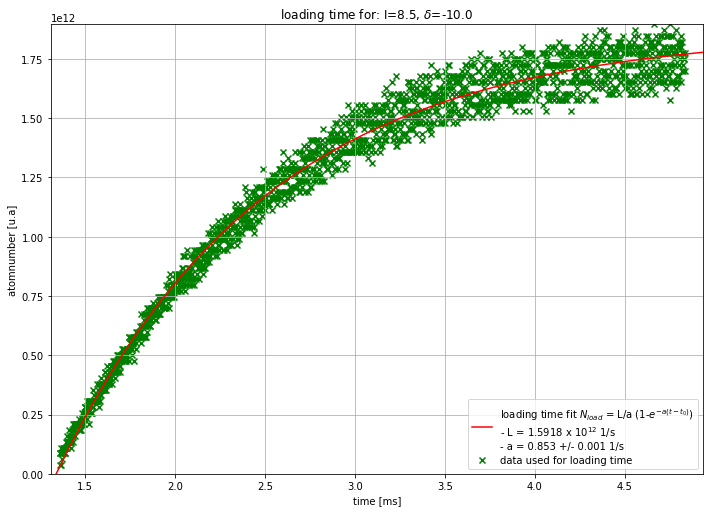

1.3414046629063152


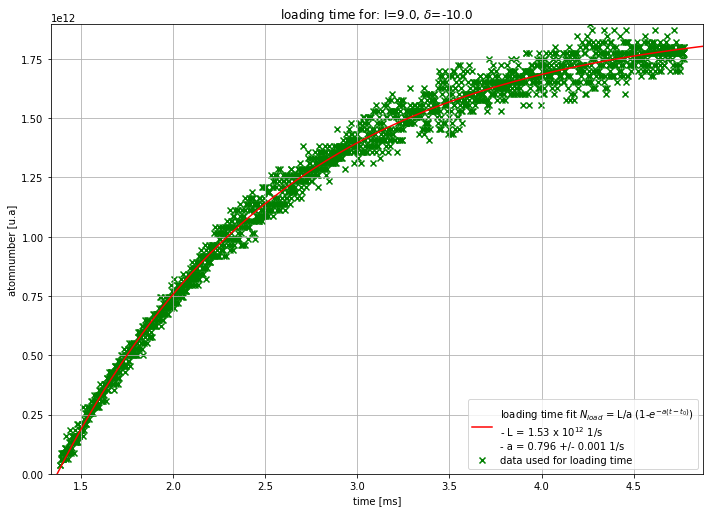

1.3700323259633422


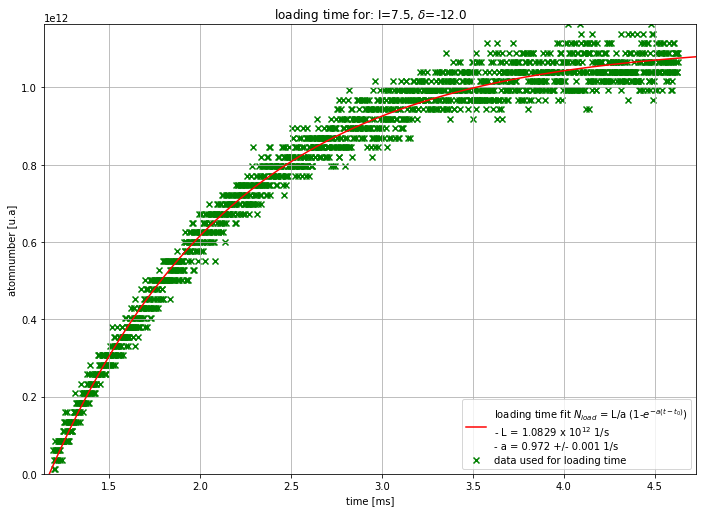

1.17306689030095


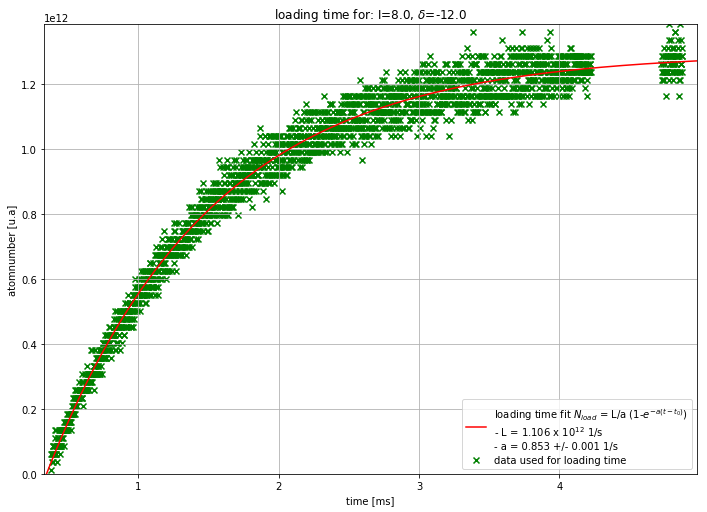

0.3466076352988428


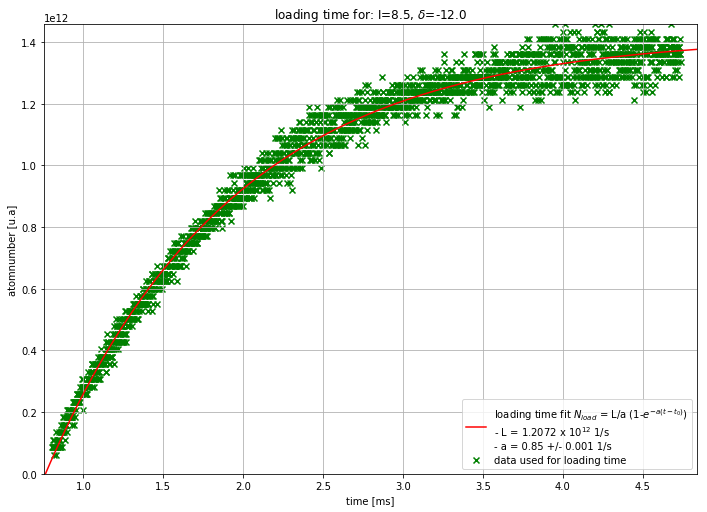

0.7617777438842571


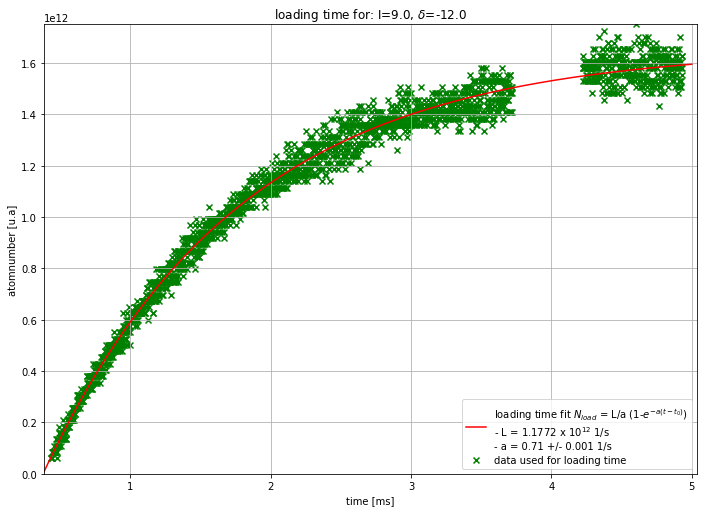

0.37783961416302125


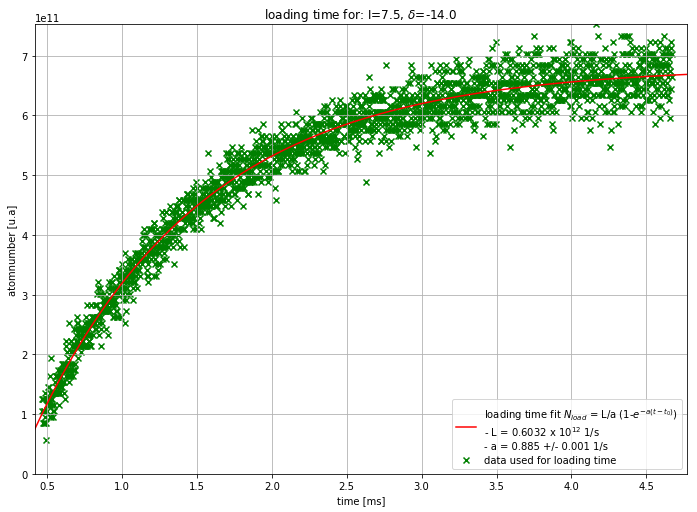

0.28792858794023707


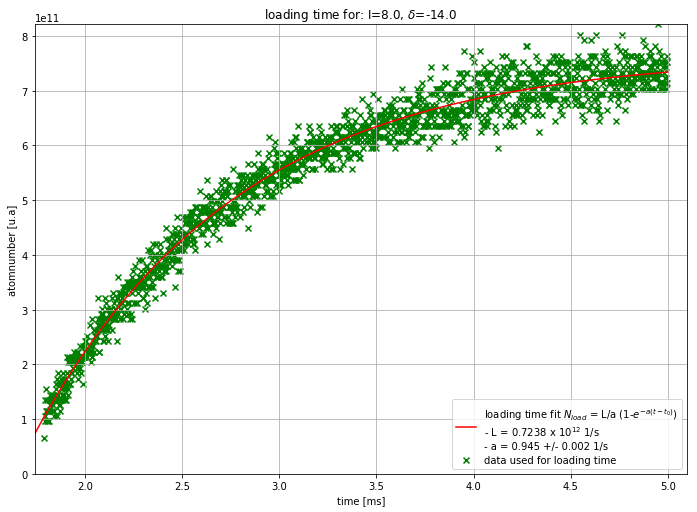

1.63452149513929


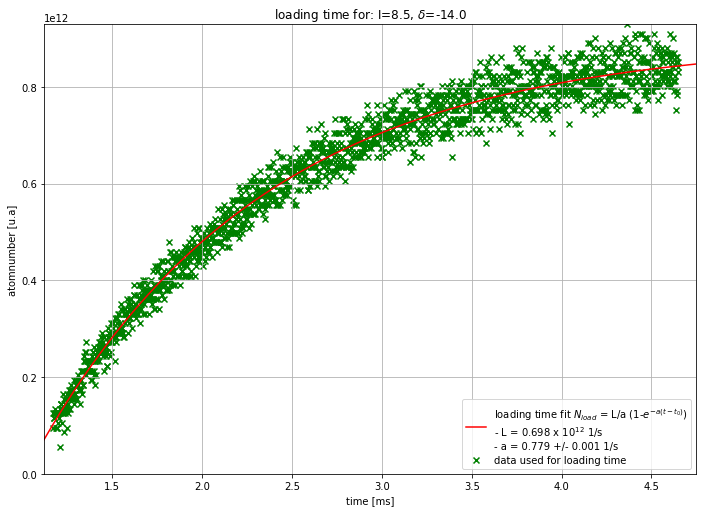

1.0143467881888892


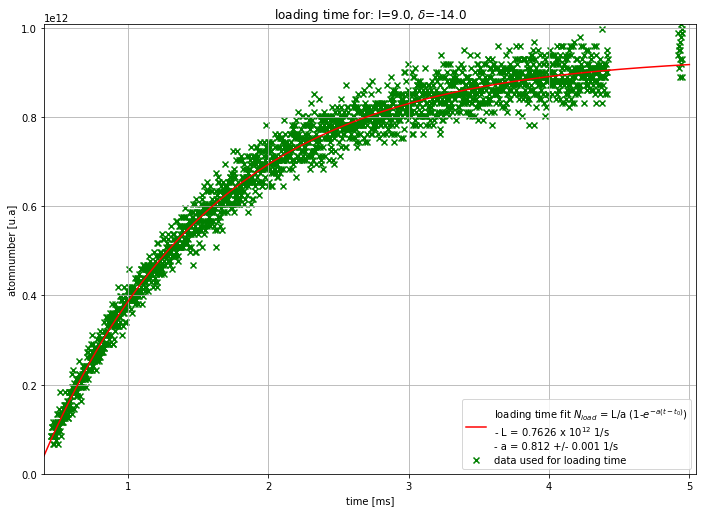

0.34718740201934967


In [90]:
#Loop goes till k, we leave out detuning 16 since it's too flat to properly fit Loading Time
l_all=np.empty((k+1,3))
a_all=np.empty((k+1,3))
af_all=np.empty((k+1,3))
for kn in karr:
    #saving tuning (tune) and current (curr) from current file
    tune=t_all[kn,0,0]
    curr=t_all[kn,0,1]
    #create working arrays t_mod and u_mod
    t_mod=t_all[kn,:,2]
    u_mod=u_all[kn,:,2]
    #creating reduced array without error values (-250 data sets)
    t_red=t_mod[np.where(u_mod > 0.025)]
    u_red=u_mod[np.where(u_mod > 0.025)]
    #find out out where the "switch off" begins
    for amou in np.arange(red_amount,dtype=int):
        if(u_red[amou]<ubd): break
    #start new array after "switch off" started
    u_temp=u_red[amou:]
    t_temp=t_red[amou:]
    #start new array after "switch on"
    u_temp2=u_temp[np.where(u_temp > 0.045)]
    t_temp2=t_temp[np.where(u_temp > 0.045)]
    #find out where the values start to become flat
    temp=np.size(t_temp2)
    for temp_2 in np.arange(temp,dtype=int):
        if(u_temp2[temp_2]>=(np.amax(u_temp2)*0.9)): break
    #converion to atom number, not used yet
    n_temp = conversion(u_temp2-0.045,tune)
    #creating final arrays
    n=n_temp#[:temp_2]
    u=u_temp2#[:temp_2]
    t=t_temp2#[:temp_2]
    #scattering final data sets
    plt.scatter(t,n,marker='x',color='green',label='data used for loading time')
    #plt.scatter(t_temp2[temp_2:],n_temp[temp_2:],marker='x',color='gray',label='masked data')
    #the fit function for Loading time
    tloading=t[0]
    def loadingTime(time,L,alpha,tshift):
        nload = L/alpha*(1-np.exp(-alpha*(time-tshift)))
        return nload
    #creating fit for loading time
    load, loadf = curve_fit(loadingTime,t,n,p0=(1e12,1,1),bounds=([1e-9,1e-4,-np.inf],[1e14,1e3,np.inf]))
    plt.plot(tplot,loadingTime(tplot,*load),color='red',label='\n'.join([
        'loading time fit $N_{load}$ = L/a (1-$e^{-a(t-t_0)})$',
        '- L = '+str(np.round(load[0]/1e12,4))+' x $10^{12}$ 1/s',#+' +/- '+str(np.round(np.sqrt(loadf[0][0]),4))+' 1/s',
        '- a = '+str(np.round(load[1],3))+' +/- '+str(np.round(np.sqrt(loadf[1][1]),3))+' 1/s']))
    l_all[kn,:]=[load[0],tune,curr]
    a_all[kn,:]=[load[1],tune,curr]
    af_all[kn,:]=[np.sqrt(loadf[1][1]),tune,curr]
    #cosmetics for plots
    plt.xlim(t[0]-0.05,t[-1]+0.1)
    plt.ylim(np.amin(n)*0,np.amax(n_temp))
    plt.legend(loc='lower right')
    plt.xlabel('time [ms]')
    plt.ylabel('atomnumber [u.a]')
    plt.title('loading time for: I='+str(curr)+', $\delta$=-'+str(tune))
    plt.gcf().set_size_inches(11.69, 8.27)
    plt.grid(True)
    plt.show()
    print(load[2])
    
    #cleaning up
    del t_mod,u_mod,t_red,u_red,t_temp,u_temp,t_temp2,u_temp2,n_temp,t,u,n
    del amou,temp, temp_2,tune,curr,load,loadf,loadingTime, tloading
    

In [32]:
print('$/alpha$')

$/alpha$
